In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model

import nltk
nltk.download('stopwords')

In [ ]:
df = pd.read_csv('../data/train.csv')
df = df.drop(columns=['Unnamed: 0'])

df.isnull().any()

In [ ]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df["preprocessed_news"] = df["preprocessed_news"].apply(review_cleaning)


In [ ]:
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_train = df.drop(['label'], axis = 1)
Y_train = df['label']

In [ ]:
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
maxlen=256
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')


vectorizer = CountVectorizer(max_features=8000)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()

##### Logistic Regression


In [ ]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train,Y_train)
lr_classifier_train = round(lr_classifier.score(X_train, Y_train) * 100, 2)

with open('../models/logisticRegression.pkl', 'wb') as arquivo:
    pickle.dump(lr_classifier, arquivo)

##### Multilayer perceptron (MLP)

In [ ]:
mlp = MLPClassifier(random_state=1)
mlp.fit(X_train,Y_train)
mlp_train = round(mlp.score(X_train, Y_train) * 100, 2)

with open('../models/MLPClassifier.pkl', 'wb') as arquivo:
    pickle.dump(mlp, arquivo)


##### Multilayer perceptron (MLP) Com GridSearchCV

In [ ]:
parameters = {'solver': ['sgd', 'lbfgs'],
              'hidden_layer_sizes':(20, 10,4), 
              'random_state':[2],
              'activation': ['tanh', 'relu'],
              'max_iter': [2000000],
              "batch_size" : ["auto"],
              "learning_rate_init": [0.004],
              "validation_fraction":[0.3],
              "learning_rate": ['constant']
              }

clf = GridSearchCV(MLPClassifier(), parameters, cv=2)
clf.fit(X_train,Y_train)
mlpG_train = round(clf.score(X_train, Y_train) * 100, 2)


with open('../models/MLPClassifierWithGridSearchCV.pkl', 'wb') as arquivo:
    pickle.dump(clf, arquivo)


#### Decision Tree

In [ ]:
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_train,Y_train)
decisionTree_train = round(clf.score(X_train, Y_train) * 100, 2)

with open('../models/decisionTree.pkl', 'wb') as arquivo:
    pickle.dump(decisionTree, arquivo)

#### RNN

In [ ]:
output_dim = 64
epochs = 200
tf.keras.backend.clear_session()

modelSimpleRNN = tf.keras.models.Sequential()
modelSimpleRNN.add(tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen))
modelSimpleRNN.add(tf.keras.layers.GRU(60, activation='tanh', return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.Conv1D(30, 3, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.LSTM(30, return_sequences=True))
modelSimpleRNN.add(tf.keras.layers.SimpleRNN(3, activation='tanh'))
modelSimpleRNN.add(tf.keras.layers.Dropout(0.25))
modelSimpleRNN.add(tf.keras.layers.Dense(24, activation='relu'))
modelSimpleRNN.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))
modelSimpleRNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historySimpleRNN = modelSimpleRNN.fit(train_padded_seqeunces, Y_train, epochs=epochs, validation_split=0.1)
rnn_train = round(historySimpleRNN.history['accuracy'][-1] * 100, 2)
modelSimpleRNN.save('../models/modelo_rnn.keras', save_format='tf')


#### LSTM (BI)

In [ ]:
output_dim = 64
epochs = 200
batch_size = 32
tf.keras.backend.clear_session()

modelLSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, output_dim, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])
modelLSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historyLSTM = modelLSTM.fit(train_padded_seqeunces, Y_train, epochs=epochs, validation_split=0.1)
LSTM_train = round(historyLSTM.history['accuracy'][-1] * 100, 2)
modelLSTM.save('../models/modelLSTM.keras', save_format='tf')

## Test

In [159]:
#df_test = pd.read_csv('../data/pre-processed.csv')

df_test = pd.read_csv('../data/dataset_0_palavras.csv')
df_test = df_test.drop(columns=['Unnamed: 0', 'ID', 'author',
       'average_word_length', 'category', 'date_publication', 'link',
       'percent_speeling_errors', 'number_words'])

df_test = df_test.rename(columns={'fake_news': 'label'})
df_test = df_test.rename(columns={'text': 'preprocessed_news'})

df_test = df_test.drop(df_test.index[400:], inplace=False)
df_test

,label,preprocessed_news
0,1,kátia abreu diz vai colocar expulsão moldura r...
1,1,blog esquerdista dá entender reclamar dedada f...
2,1,alckmin diz psdb desembarca explica utilizará ...
3,1,cara pau limites zé celso aciona mp contra sil...
4,1,temer resolve problema luislinda liberdade ain...
...,...,...
395,1,repórter folha ironiza atuação sérgio moro tom...
396,1,malafaia defende bolsonaro acaba folha sp jorn...
397,1,número seguidores redes sociais pode definir e...
398,1,delegado pf denuncia plano falso atentado cont...


In [160]:
maxlen=256


stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(remover_stop_words)
df_test["preprocessed_news"] = df_test["preprocessed_news"].apply(review_cleaning)

df_test['label'] = df_test.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)

X_test = df_test['preprocessed_news'].apply(lambda x: x.lower())

test_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
test_tokenizer.fit_on_texts(X_test.values)
test_word_index = test_tokenizer.word_index
test_sequences = test_tokenizer.texts_to_sequences(X_test)
vocab_length = len(test_word_index) + 1
maxlen=256
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')


vectorizer = CountVectorizer(max_features=8000)
vectorizer.fit(X_test)
X_test = vectorizer.transform(X_test).toarray()
Y_test = df_test['label']


In [161]:
with open('../models/logisticRegression.pkl', 'rb') as arquivo:
    lr_classifier = pickle.load(arquivo)
with open('../models/MLPClassifier.pkl', 'rb') as arquivo:
    mlp = pickle.load(arquivo)
with open('../models/MLPClassifierWithGridSearchCV.pkl', 'rb') as arquivo:
    mlpG = pickle.load(arquivo)
with open('../models/decisionTree.pkl', 'rb') as arquivo:
    decisionTree = pickle.load(arquivo)
    
rnn = load_model('../models/modelo_rnn.keras')
modelLSTM = load_model('../models/modelLSTM.keras')


##### Logistic Regression


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     400.0

    accuracy                           0.00     400.0
   macro avg       0.00      0.00      0.00     400.0
weighted avg       0.00      0.00      0.00     400.0



c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

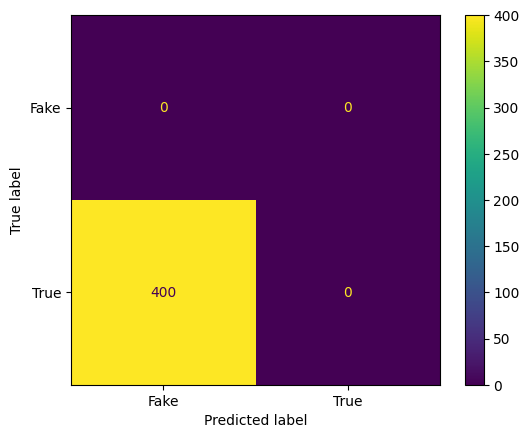

In [162]:
y_test_pred = lr_classifier.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
lr_classifier_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)
cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()



##### Multilayer perceptron (MLP)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.66      0.79       400

    accuracy                           0.66       400
   macro avg       0.50      0.33      0.40       400
weighted avg       1.00      0.66      0.79       400



c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

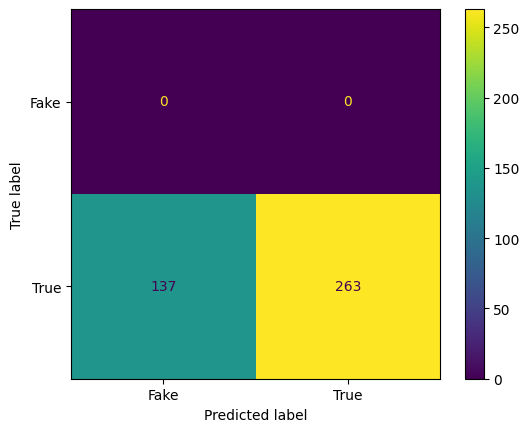

In [163]:
y_test_pred = mlp.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlp_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


##### Multilayer perceptron (MLP) Com GridSearchCV

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.01      0.01       400

    accuracy                           0.01       400
   macro avg       0.50      0.00      0.00       400
weighted avg       1.00      0.01      0.01       400



c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

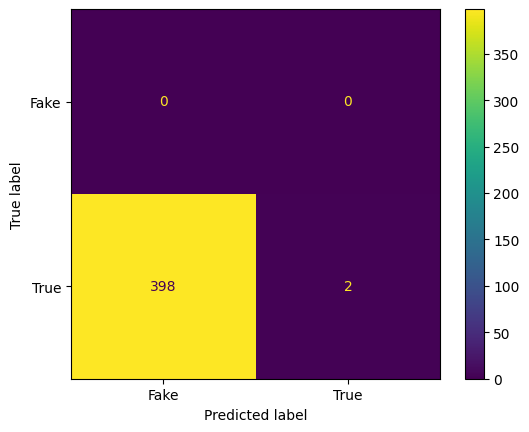

In [164]:

y_test_pred = mlpG.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
mlpG_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()

    

#### Decision Tree

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.07      0.13       400

    accuracy                           0.07       400
   macro avg       0.50      0.04      0.07       400
weighted avg       1.00      0.07      0.13       400



c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

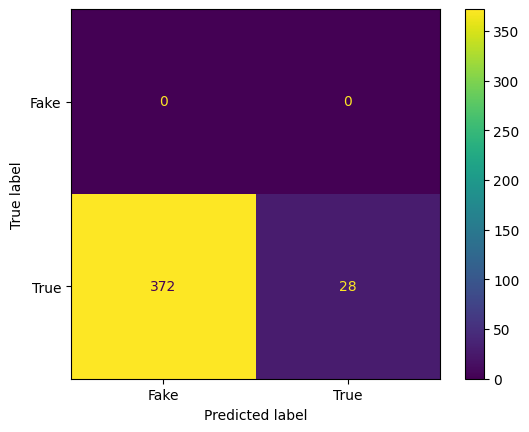

In [165]:
y_test_pred = decisionTree.predict(X_test)
y_test_pred = (y_test_pred > 0.75)
decisionTree_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### RNN

13/13 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.10      0.19       400

    accuracy                           0.10       400
   macro avg       0.50      0.05      0.09       400
weighted avg       1.00      0.10      0.19       400



c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

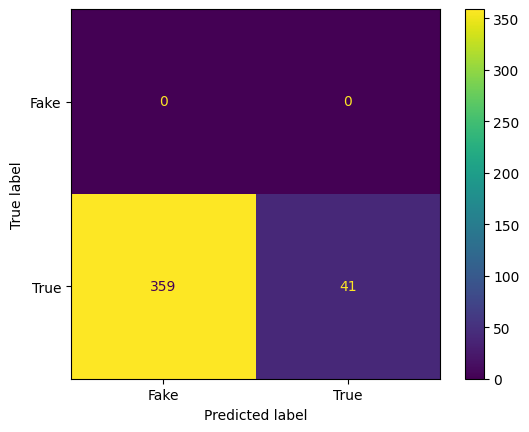

In [166]:

y_test_pred = rnn.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
rnn_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


#### LSTM(BI)

13/13 [==============================] - 2s 46ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.38      0.55       400

    accuracy                           0.38       400
   macro avg       0.50      0.19      0.27       400
weighted avg       1.00      0.38      0.55       400



c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

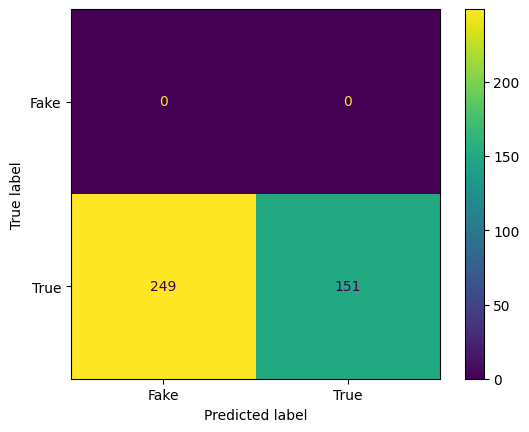

In [167]:

y_test_pred = modelLSTM.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
lstm_acc = round(accuracy_score(Y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(Y_test, y_test_pred)
print(classification_report(Y_test, y_test_pred))

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake','True']).plot()


### Comparando Modelos Diferentes

In [168]:
model = pd.DataFrame({
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'MLPClassifier',
        'MLPClassifier with grid',
        'RNN',
        'RNN LSTM(BI)'
    ],
    'Model Accuracy Score': [
        lr_classifier_acc, decisionTree_acc,
        mlp_acc, mlpG_acc,rnn_acc,lstm_acc
    ]
})

In [169]:
model = model.sort_values('Model Accuracy Score',ascending=False)
model

,Model,Model Accuracy Score
2,MLPClassifier,65.75
5,RNN LSTM(BI),37.75
4,RNN,10.25
1,Decision Tree,7.00
3,MLPClassifier with grid,0.50
0,Logistic Regression,0.00


In [170]:
df_subset = df_test.drop(df_test.index[1:], inplace=False)
df_subset.to_csv('../data/sub_test.csv', index=False)
df_subset.preprocessed_news = "O número de feminicídios aumentou durante o governo Bolsonaro. Os dados do Anuário Brasileiro de Segurança Pública mostraram que em 2018 último ano antes de ele assumir como presidente o Brasil teve um total de 1.229 casos (página 157). Nos dois primeiros anos do governo Bolsonaro o número aumentou para 1.330 em 2019 e 1.354 em 2020. Em 2021 o número caiu para 1.341 mas seguiu acima do patamar de 2018."

new_row = new_row = pd.DataFrame({'index': [1], 'label': ['0'], 'preprocessed_news': ["Não pega fogo na floresta amazônica. Isso é falácia – Jair Bolsonaro (PL) presidente e candidato à reeleição em sabatina da RedeTV em 1 de setembro de 2022"]})
df_subset = pd.concat([df_subset, new_row], ignore_index=True)
new_row = new_row = pd.DataFrame({'index': [2], 'label': ['1'], 'preprocessed_news': ["Hoje você leva em média um dia para abrir uma empresa – Jair Bolsonaro (PL) presidente e candidato à reeleição em sabatina da RedeTV em 1 de setembro de 2022"]})
df_subset = pd.concat([df_subset, new_row], ignore_index=True)

new_row = new_row = pd.DataFrame({'index': [1], 'label': ['1'], 'preprocessed_news': [",historia fisico minas marte brasileiro ivair gontijo narra livro participacao missao curiosity agosto curiosity pousava marte maior sofisticado veiculo espacial ser enviado sucesso outro planeta radares permitiram pouso momento critico missao projetados equipe liderada fisico brasileiro ivair gontijo pesquisador jet propulsion laboratory jpl agencia espacial americana nasa novo livro caminho marte acaba ser lancado gontijo conta nao apenas detalhes aventura envolveu projeto lancamento pouso historico curiosity tambem singular trajetoria pessoal criado pequena cidade moema margens rio sao francisco interior minas gerais gontijo decidiu trocar emprego fazenda curso fisica universidade federal minas gerais deixando familiares incredulos so comeco antes chegar nasa ainda fez doutorado escocia estados unidos elon musk divulga design atualizado proximo lancador espacial objetivo livro mostrar estudantes brasileiros geral conseguir algo trabalhar nasa alcance maioria pessoas disposta pagar preco preco alto horas trabalho estudo foco planejamento disse gontijo estado autor intercala narrativa propria trajetoria historia estudos sobre marte segundo apaixonado humanidade ha seculos cientistas precisamos tornar ciencia acessivel emocionante populacao porque nenhum pais vai frente muita ciencia tecnologia procuro mostrar ciencia pode ser tao emocionante gol final copa mundo afirmou conseguir emprego nasa segundo gontijo extremamente dificil alem formacao solida anos estudo intenso preciso armar insistencia astronomica nao primeira vez bati porta nasa consegui entrar primeira vez fiz entrevista ofereceram emprego temporario achei nao valia pena contato gerente missoes avisou precisavam alguem perfil deu pessoas laboratorio ninguem nunca respondeu nao desisti conta dia engenheiro jpl ligou dizendo encontrou curriculo site conferencia precisavam pessoa exatamente formacao fiz entrevista nao deu certo preciso esperar ano conto todos detalhes livro disse fisico missao segundo gontijo curiosity veiculo sofisticado ja construido enviado outro planeta tarefa dificultada tamanho veiculo semelhante carro compacto curiosity pesaria quilos terra possui mastro dois metros altura missao anterior envolvia veiculo menor torno quilos tecnologia toda viabilizar pouso curiosity marte nao existia antes tecnologia utilizamos missoes anteriores airbags nao funcionaria nessa circunstancia tinhamos fazer veiculo descer rodas explicou segundo cientista trabalho missao dessas dimensoes exigente tenso momentos criticos lancamento pouso basta falha milhares possiveis perderem anos trabalho bilhoes dolares processo descida marte ficou conhecido sete minutos terror porque veiculo aproximando planeta mil quilometros hora rota colisao queda livre velocidade precisava ser reduzida zero apenas sete minutos contou antes descida capsula continha curiosity perde energia atmosfera marciana usando escudo frontal calor paraquedas utilizado reduzir ainda velocidade descida final ultimos quatro seis quilometros usamos retrofoguetes explica voo controlado retrofoguetes veiculo colocado chao guindaste seguida afasta nao causar danos equipamento correu tudo melhor esperavamos vi colega sala controle dizendo achamos solo radar realmente acreditei daria certo seguida lembro comemoracoes sala controle muitos gritos lagrimas espetacular lembra radares gontijo nao funcionassem curiosity espatifaria superficie marciana tudo estaria perdido colegas diziam radares nao funcionassem todo resto irrelevante porque veiculo viraria monte ferro velho superficie marte projeto custou us bilhoes entao tensao grande acordo gontijo missao curiosity ja terminou oficialmente veiculo continua fazendo pesquisas superficie marciana onde percorreu pouco quilometros ja encontramos leito seco rio fundo lago rochas sedimentares locais onde havia agua ph neutro pessoa poderia beber operadores nasa recebem dados curiosity diariamente ate hoje apos recepcao dados cientificos sao discutidos fotos sao analisadas engenheiros tecnicos cientistas decidem fazer dia seguinte comandos sao programados enviados marte todos dias satelite orbita planeta satelite repassa dados veiculo solo executa comandos coleta dados tarde marciana transmite novos dados direcao ceu marciano onde passara satelite reenvia terra explicou futuro atualmente gontijo trabalhando proxima missao marte mars enviara planeta vermelho veiculo semelhante curiosity novo veiculo tera conjunto diferente instrumentos descera local distinto ideia coletor amostras disse cientista amostras coletadas veiculo mars serao colocadas roboticamente tubos serao selados hermeticamente deixados superficie planeta segunda missao sera enviada coletar amostras serao colocadas pequeno foguete enviadas orbita marte ali amostras vao ficar girando torno marte terceira missao simples barata saira entao terra encontrara amostras orbita marte trara tudo volta terra necessario porque terra laboratorios sofisticados analisar amostras chegam ocupar predio inteiro nenhum instrumento possa ser enviado atualmente marte mesma capacidade analise objetivos exploracao marte segundo gontijo encontrar vestigios vida planeta cientistas vestigio fossil forma primitiva vida bacteria totalmente extinta ja descoberta historica igual talvez maiores descobertas especie humana todos seres vivos terra mesma origem todos virus seres humanos usamos processo codificacao dna vida formar outro planeta sera usaria processo nao sabemos dia descobrirmos vida terra sera primeira coisa ser estudada sao processos formam vida outro planeta descoberta espetacular"]})
df_subset = pd.concat([df_subset, new_row], ignore_index=True)
new_row = new_row = pd.DataFrame({'index': [2], 'label': ['1'], 'preprocessed_news': [",relator lava jato nega pedido lula ser ouvido advogados lula haviam pedido prestasse novo depoimento defesa apresentou nesta novos documentos sobre propriedade triplex tribunal regional federal regiao nao vai ouvir luiz inacio lula silva antes julgamento apelacao marcado janeiro primeira instancia politico condenado anos meses corrupcao passiva lavagem dinheiro processo lava jato envolvendo triplex advogados lula haviam protocolado dois pedidos lula ouvido antes julgamento recurso setembro outro inicio janeiro decisao relator processos lava jato tribunal joao gebran neto diz eventual deferimento reinterrogatorio passa necessariamente apreciacao alegacoes invalidade daquele prestado perante juizo origem alem disso gebran cita jurisprudencias anteriores negaram pedidos semelhantes ressalta faculdade decidir novo depoimento somente juizo nao reu acusacao apelacao defesa tambem pede inocentado acusacao ocultacao propriedade imovel recebido propina empreiteira oas troca favores petrobras defesa moro nao interesse apurar fatos nesta advogados lula protocolaram apelacao novos documentos segundo defesa reforcariam oas proprietaria triplex decisao proferida dezembro juizo vara execucao titulos distrito federal autos processo determinou penhora apartamento condominio solaris guaruja sp satisfacao divida oas matricula atualizada cartorio imoveis municipio tambem incluida peticao documentos defesa reforca propriedade imovel pertence oas nao lula sentenca juiz sergio moro permite recorra liberdade setembro advogados lula ja haviam ingressado pedido relator processos lava jato desembargador joao gebran neto porem segundo assessoria imprensa defesa pedido nao apreciado motivou novo pedido julgamento recurso apresentado defesa lula sera realizado dia janeiro sede tribunal regional regiao porto alegre justica federal parana tambem determinou bloqueio r milhoes estabelecido dano minimo sequestro apartamento lula tambem bloqueados r mil contas bancarias cerca r milhoes depositados dois planos previdencia privada outros dois reus processo tambem condenados quatro absolvidos movimento terra mst havia anunciado acampamento manifestar apoio lula durante julgamento proibido justica realizar protesto dessa maneira despacho publicado dezembro neto proibiu instalacao acampamento movimento trabalhadores rurais terra mst area parque terrenos vizinhos ate tres dias apos julgamento manifestantes poderao acessar area caso desembargadores decidam manter decisao primeira instancia podem determinar prisao lula caso executada moro curitiba decidir so ira prisao apos todos recursos terem sido esgotados supremo tribunal federal stf determinou reu condenado segunda instancia ja comece cumprir pena prisao recorrendo tribunais superiores assunto porem deve voltar ser discutido ministros ainda nao ha data julgamento inelegibilidade lula vez assunto justica eleitoral lei ficha limpa preve condenado segunda instancia caso caso desembargadores confirmem sentenca nao pode candidatar eventual condenacao si so nao influenciaria possivel candidatura neste caso decisao ficaria conta tribunal superior eleitoral tse pode ser acionado ministerio publico eleitoral mpe algum adversario politico ainda decidir iniciativa propria magistrado"]})
df_subset = pd.concat([df_subset, new_row], ignore_index=True)



In [171]:
df_subset

,label,preprocessed_news,index
0,1,O número de feminicídios aumentou durante o go...,NaN
1,0,Não pega fogo na floresta amazônica. Isso é fa...,1.0
2,1,Hoje você leva em média um dia para abrir uma ...,2.0
3,1,",historia fisico minas marte brasileiro ivair ...",1.0
4,1,",relator lava jato nega pedido lula ser ouvido...",2.0


In [172]:
df_subset["preprocessed_news"] = df_subset["preprocessed_news"].apply(remover_stop_words)
df_subset["preprocessed_news"] = df_subset["preprocessed_news"].apply(review_cleaning)


X_test = df_subset['preprocessed_news'].apply(lambda x: x.lower())

test_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
test_tokenizer.fit_on_texts(X_test.values)
test_word_index = test_tokenizer.word_index
test_sequences = test_tokenizer.texts_to_sequences(X_test)
vocab_length = len(test_word_index) + 1
maxlen=256
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')


vectorizer = CountVectorizer(max_features=8000)
vectorizer.fit(X_test)
X_test = vectorizer.transform(X_test).toarray()
Y_test = df_subset['label']


In [173]:

y_test_pred = rnn.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.5).astype(int)

print(y_test_pred)


y_test_pred = modelLSTM.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.5).astype(int)

print(y_test_pred)




1/1 [==============================] - 0s 36ms/step
[[0]
 [0]
 [0]
 [1]
 [1]]
1/1 [==============================] - 0s 41ms/step
[[0]
 [0]
 [0]
 [1]
 [1]]
